In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline  
import os
import glob
from utils import *
import matplotlib.pyplot as plt
from ast import literal_eval
import pandas as pd
import datetime as dt
plt.rcParams['axes.facecolor']='w'
import math
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 16

In [2]:
scored_full = TweetsDataFrame.read_csv('./scored_tweets/scored_270_4528_sorted.csv')
scored_full['createdAt'] =  scored_full.index
scored=scored_full[constants.STARTDATE:constants.FIRST_ROUND]
scored = scored.filter(['createdAt', 'user_id', 'candidate_ref', 'score_neg', 'score_pos'])

In [3]:
def get_mentions(df):
    mentions = df.groupby('candidate_ref').count()['createdAt']
    mentions.name = df.index.max()
    return pd.DataFrame(mentions).transpose()
    
def mentions_df(df, bdate, edate, step):
    mentions_df = pd.DataFrame()
    time = bdate
    end = edate
    time_step = step
    while time < end:
        new_mentions_df = get_mentions(df[time-2*time_step:time])
        if mentions_df.empty:
            mentions_df = new_mentions_df
        else:
            mentions_df = mentions_df.append(new_mentions_df)

        time += time_step
    return mentions_df

In [4]:
def get_ratio(group):
    s = group['score_pos']+group['score_neg']
    max_pos = s.max()
    min_neg = s.min()
    t = (max_pos - min_neg)/float(2) + min_neg
    return pd.Series([t]*len(group), index=group.index)

In [5]:
scored_for_ratio = scored.reset_index(drop=True)
scored_for_ratio.index = scored_for_ratio.index.astype(int)

In [6]:
threshold = scored_for_ratio.groupby(scored_for_ratio['createdAt'].apply(lambda d: d.date())).apply(lambda x: x.groupby('candidate_ref').apply(get_ratio))
t = threshold.reset_index().set_index('level_2')
del t.index.name
t.sort_index(inplace=True)

In [17]:
scored_for_ratio['ratio'] = t[0]
scored_for_ratio.index = scored_for_ratio['createdAt']

In [18]:
##First Scenario
#only_pos = scored[scored['score_neg']+scored['score_pos'] > 0]
#only_neg = scored[scored['score_neg'] + scored['score_pos'] < 0]

## Second Scenario
#only_pos = scored[scored['score_neg']+scored['score_pos'] > 4]
#only_neg = scored[scored['score_neg'] + scored['score_pos'] < 0]

## Adapted Scenario
only_pos = scored_for_ratio[(scored_for_ratio['score_neg']+scored_for_ratio['score_pos']) > scored_for_ratio['ratio']]
only_neg = scored_for_ratio[(scored_for_ratio['score_neg']+scored_for_ratio['score_pos']) < 0]
print('pos : '+str(len(only_pos)))
print('neg : '+str(len(only_neg)))

pos : 5109171
neg : 1203933


In [19]:
begin = constants.STARTDATE
end = constants.FIRST_ROUND
step = dt.timedelta(days=1)
pos_mentions = mentions_df(only_pos,begin , end, step)
neg_mentions = mentions_df(only_neg,begin , end, step)

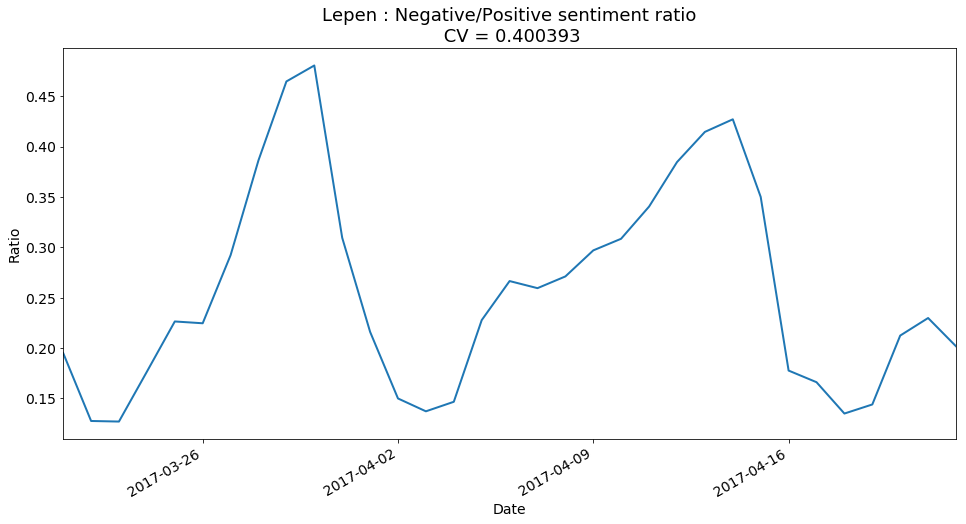

In [21]:
candidate = 'Lepen'
fig, ax0 = plt.subplots(facecolor='w', figsize=(16,8))
ratio = neg_mentions[candidate].reset_index()[candidate].div(pos_mentions[candidate].reset_index()[candidate])
ratio.index=neg_mentions.index
ratio.plot(ax=ax0, )
ax0.set_title('%s : Negative/Positive sentiment ratio'%candidate\
             +'\n CV = %.6f'%(ratio.std()/ratio.mean()))
ax0.set_xlabel('Date')
ax0.set_ylabel('Ratio')
plt.show()

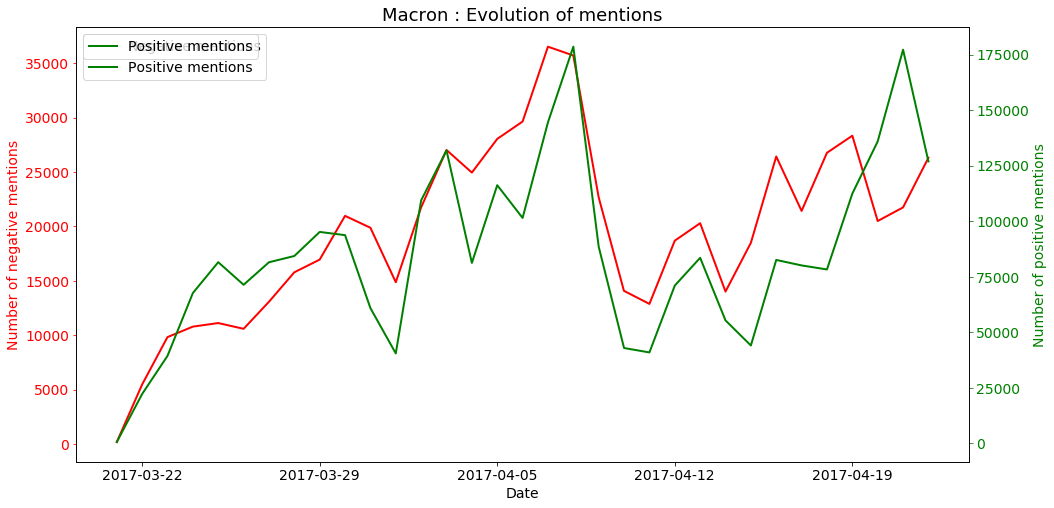

In [23]:
candidate = 'Macron'
fig, ax0 = plt.subplots(facecolor='w', figsize=(16,8))

#ln0 = neg_mentions[candidate].plot(ax=ax0, c='r', label='Negative mentions',)
ln0 = ax0.plot(neg_mentions[candidate], c='r', label='Negative mentions')

ax1=ax0.twinx()
ln1 = ax1.plot(pos_mentions[candidate], c='g', label='Positive mentions')
#ln1 = pos_mentions[candidate].plot(ax=ax1, c='g', label='Positive mentions' )
ax0.tick_params('y', colors='r')
ax1.tick_params('y', colors='g')
ln = ln0+ln1
labs = [l.get_label() for l in ln]
ax0.legend(ln, labs, loc='upper left')
ax0.set_ylabel('Number of negative mentions')
ax0.yaxis.label.set_color('red')
ax1.set_ylabel('Number of positive mentions')
ax1.yaxis.label.set_color('g')
ax0.set_xlabel('Date')
ax0.set_title('%s : Evolution of mentions'%candidate)
#ax0.set_xlim(constants.FIRST_ROUND)
plt.legend()
plt.show()